In [1]:
pip install image_similarity_measures

     |████████████████████████████████| 2.6 MB 7.4 MB/s 
     |████████████████████████████████| 19.3 MB 163 kB/s 
  Created wheel for phasepack: filename=phasepack-1.5-py3-none-any.whl size=26983 sha256=96fb5cb6a0c77443ba943f05a8f380ed72745a58e6052e4e526ca11689412eff
  Stored in directory: /root/.cache/pip/wheels/39/5c/b3/79292d7ac3f088e858805b5515b45cf5a365106397d936caf1
Successfully built phasepack


In [4]:
from keras.datasets import mnist, cifar10
from keras.models import Sequential, load_model
from keras.layers.core import Activation
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import np_utils
from time import time
import cv2
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D
from keras.constraints import maxnorm
from keras import backend as K 
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
import image_similarity_measures
from image_similarity_measures.quality_metrics import rmse, ssim, sre, issm, sam, uiq, fsim, psnr

np.random.seed(100)

In [5]:
def preprocess(dataset='mnist'):
  if (dataset == 'mnist'):
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    X_train = X_train / 255
    X_test = X_test / 255
    X_train_Flatten = X_train.reshape(len(X_train), X_train[0].shape[0]*X_train[0].shape[1])
    X_test_Flatten = X_test.reshape(len(X_test), X_train[0].shape[0]*X_train[0].shape[1])
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    y_test = np_utils.to_categorical(y_test, 10)
    y_train = np_utils.to_categorical(y_train, 10)
  else:
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    X_train = X_train / 255
    X_test = X_test / 255
    X_train_Flatten = X_train.reshape(len(X_train), X_train[0].shape[0]*X_train[0].shape[1]*X_train[0].shape[2])
    X_test_Flatten = X_test.reshape(len(X_test), X_train[0].shape[0]*X_train[0].shape[1]*X_train[0].shape[2])
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    y_test = np_utils.to_categorical(y_test, 10)
    y_train = np_utils.to_categorical(y_train, 10)
  return (X_train, y_train), (X_test, y_test), (X_train_Flatten, X_test_Flatten)


In [6]:
class GeneticAdversarial:
  def __init__(self, dataset, model, modelType, myPicShape, myPicOriginal, myPic, target , epsilon = 0.005, sizeOfPopulation = 50, numIterations = 5000, mutation = 0.05, elitProportionSize = 0.3):
    self.myPic = myPic
    self.target = target
    self.epsilon = epsilon
    self.image_shape = (int(np.sqrt(np.shape(myPic)[0])), int(np.sqrt(np.shape(myPic)[0])))
    self.image_flattend_size = np.shape(myPic)[0]
    self.sizeOfPopulation = sizeOfPopulation
    self.mutationRate = mutation
    self.elitProportionSize = elitProportionSize
    self.numIterations = numIterations
    self.model = model
    self.modelType = modelType
    self.dataset = dataset
    self.myPicShape = myPicShape
    self.myPicOriginal = myPicOriginal
  
  def initiate_populatoin(self):
    pass

  
  def fitnessFunction(self, image):
    if self.modelType == 'ANN':
      listOfProbabilities = self.model.predict(np.array(image).reshape(-1, self.image_flattend_size))
      fitnessValue = listOfProbabilities[0][self.target-1]
    elif self.modelType == 'CNN':
      if self.dataset == 'mnist':
        listOfProbabilities = self.model.predict(np.array(image).reshape((1, 28, 28, 1)))
      else:
        listOfProbabilities = self.model.predict(np.array(image).reshape((1, 32, 32, 3)))
      fitnessValue = listOfProbabilities[0][self.target-1]
      
    return fitnessValue

  def fitness2(self, image):
    if self.modelType == 'ANN':
      return np.argmax(self.model.predict(np.array(image).reshape(-1, self.image_flattend_size)))
    else:
      if self.dataset == 'mnist':
        return np.argmax(self.model.predict(np.array(image).reshape((1, 28, 28, 1))))
      else:
        return np.argmax(self.model.predict(np.array(image).reshape((1, 32, 32, 3))))


  def newPopulation(self, oldPopulation):
    newPop = []
    newOld = []
    listOfValues = []
    for index, value in enumerate(oldPopulation):
        ff = self.fitnessFunction(value)
        newOld.append((index, ff))
    
    newOld = sorted(newOld, key = lambda x: x[1], reverse=True)[:int(self.elitProportionSize*len(oldPopulation))]
    for item in newOld:
      newPop.append(oldPopulation[item[0]])

    while (len(oldPopulation) != len(newPop)):
      m = np.random.choice(len(newOld))
      d = np.random.choice(len(newOld))

      mom = oldPopulation[newOld[m][0]]
      dad = oldPopulation[newOld[d][0]]

      child1, child2 = self.crossover(mom, dad)


      if (len(newPop) + 1 <= len(oldPopulation)):
        newPop.append(self.mutate(child1))
      if (len(newPop) + 1 <= len(oldPopulation)):
        newPop.append(self.mutate(child2))

    listOfValues = []

    for index, value in enumerate(newPop):
        ff = self.fitnessFunction(value)

        listOfValues.append(ff)

    return newPop, min(listOfValues)

  def mutate(self, image):
    if np.random.uniform(0, 1) <= self.mutationRate:
      pixels = np.random.randint(0, 100)
      directions = np.random.randint(-1, 2, pixels)
      for index, value in enumerate(directions):
        image[np.random.randint(0, self.image_flattend_size)] += self.epsilon * value
      for i in range(pixels):
        image[np.random.randint(len(image))] = np.random.uniform(0,1)

      return image
    else:
      return image
  

  def crossover(self, image1, image2):
    pass
  
  def main(self):
    time1 = time()
    pop = self.initiate_populatoin()
    #print(f"initial population has {len(pop)} elements")
    plottingTheProgress = []
    for i in range(self.numIterations):
      pop, best = self.newPopulation(pop)
      plottingTheProgress.append(best)
      pop = list(pop)
      #print(f"length of population: {len(pop)}")
      counter = 0
      for m in (pop):
        if self.fitness2(m) == self.target -1:
          counter += 1
      
      if counter == 1:
        print(f"First adversarial image is found at iteration number {i} iterations, after {time()-time1} seconds")
      if (counter>=len(pop)):
        print(f"All population are adversarial images after {i} iterations, after {time()-time1} seconds")
        break
    
    time2 = time()
    plt.plot(plottingTheProgress)
    plt.show()
    fig = plt.figure()
    plt.figure(figsize=(12, 12))
    for i in range(1, len(pop)+1):
      plt.subplot(4,5,i)
      plt.imshow(np.reshape(pop[i-1], newshape=self.myPicShape))
      plt.title(f"{str(round(self.fitnessFunction(pop[i-1]), 2))}")
      plt.axis('off')
    return pop, np.absolute(time1 - time2)

In [14]:
class GeneticAdversarialRandom(GeneticAdversarial):
  def initiate_populatoin(self):
    my_initial_population = []
    for i in range(self.sizeOfPopulation):
        my_random_direction = np.random.randint(-1,2, self.image_flattend_size)
        my_modified_image = self.myPic + self.epsilon * my_random_direction
        my_initial_population.append(my_modified_image)
    
    return my_initial_population
  

  def crossover(self, image1, image2):
    which_type = 1
    child1 = []
    child2 = []
    if which_type == 0:
      randomPointOfSepration = np.random.randint(0, self.image_flattend_size)
      child1.extend(image1[:randomPointOfSepration])
      child1.extend(image2[randomPointOfSepration:])
      child2.extend(image2[:randomPointOfSepration])
      child2.extend(image1[randomPointOfSepration:])
    elif which_type == 1:
      for k in range(len(image1)):
        child1.append(max(image1[k], image2[k]))
      for k in range(len(image1)):
        child2.append((image1[k] + image2[k])/2)
    return child1, child2
  
class GeneticAdversarialRandomGumbelSSIM(GeneticAdversarial):
  def initiate_populatoin(self):
    my_initial_population = []
    for i in range(self.sizeOfPopulation):
        my_random_direction = np.random.gumbel(0,self.epsilon, self.image_flattend_size)
        my_modified_image = self.myPic + my_random_direction
        my_initial_population.append(my_modified_image)

    return my_initial_population

  def crossover(self, image1, image2):
    which_type = 1
    child1 = []
    child2 = []
    s1 = ssim(np.reshape(image1, np.shape(self.myPicOriginal)), self.myPicOriginal)
    s2 = ssim(np.reshape(image2, np.shape(self.myPicOriginal)), self.myPicOriginal)

    if which_type == 0:
      while (1):
        randomPointOfSepration = np.random.randint(0, self.image_flattend_size)
        child1.extend(image1[:randomPointOfSepration])
        child1.extend(image2[randomPointOfSepration:])
        child2.extend(image2[:randomPointOfSepration])
        child2.extend(image1[randomPointOfSepration:])
        
        s1Prime = ssim(np.reshape(child1, np.shape(self.myPicOriginal)), self.myPicOriginal)
        s2Prime = ssim(np.reshape(child2, np.shape(self.myPicOriginal)), self.myPicOriginal)

        if (s1Prime <= s1 and s1Prime <= s2):
          if (s2Prime <= s1 and s2Prime <= s2):
            break
    
    elif which_type == 1:
      for k in range(len(image1)):
        child1.append(max(image1[k], image2[k]))
      for k in range(len(image1)):
        child2.append((image1[k] + image2[k])/2)
    return child1, child2

In [8]:
(X_train, y_train), (X_test, y_test), (X_train_Flatten, X_test_Flatten) = preprocess('cifar10')

170508288/170498071 [==============================] - 4s 0us/step


In [10]:
model_cifar_cnn = load_model("model_cifar_cnn.h5")

In [15]:
myPic = X_test_Flatten[34].copy()
myPicOriginal = X_test[34].copy()
myPicShape = X_test[0].shape
myObj = GeneticAdversarialRandomGumbelSSIM('cifar', model_cifar_cnn, 'CNN', myPicShape, myPicOriginal, myPic, 1, 0.005, 20, 5000, 0.1, 0.3)

All population are adversarial images after 6 iterations, after 18.219233989715576 seconds


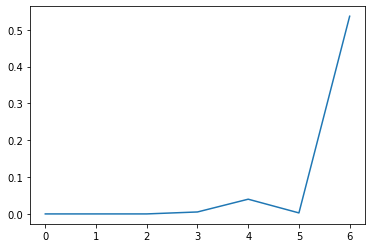

<Figure size 432x288 with 0 Axes>

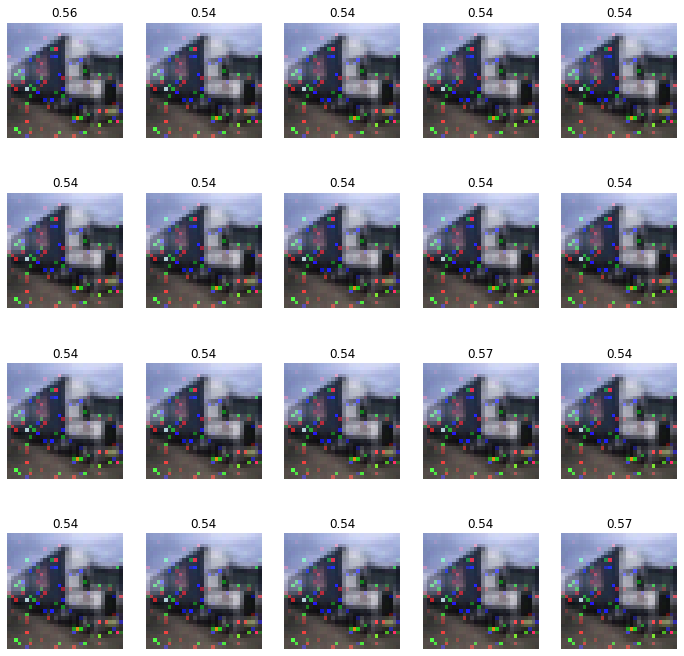

In [16]:
population , time_ = myObj.main()

In [17]:
model_cifar_cnn = load_model("model_cifar_ann.h5")

In [18]:
myPic = X_test_Flatten[34].copy()
myPicOriginal = X_test[34].copy()
myPicShape = X_test[0].shape
myObj = GeneticAdversarialRandomGumbelSSIM('cifar', model_cifar_cnn, 'ANN', myPicShape, myPicOriginal, myPic, 1, 0.005, 20, 5000, 0.1, 0.3)

First adversarial image is found at iteration number 22 iterations, after 57.091124057769775 seconds
First adversarial image is found at iteration number 23 iterations, after 59.59142541885376 seconds
First adversarial image is found at iteration number 24 iterations, after 62.026005268096924 seconds
First adversarial image is found at iteration number 25 iterations, after 64.67052388191223 seconds
First adversarial image is found at iteration number 26 iterations, after 67.18506860733032 seconds
All population are adversarial images after 31 iterations, after 80.02086544036865 seconds


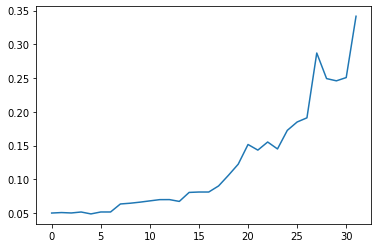

<Figure size 432x288 with 0 Axes>

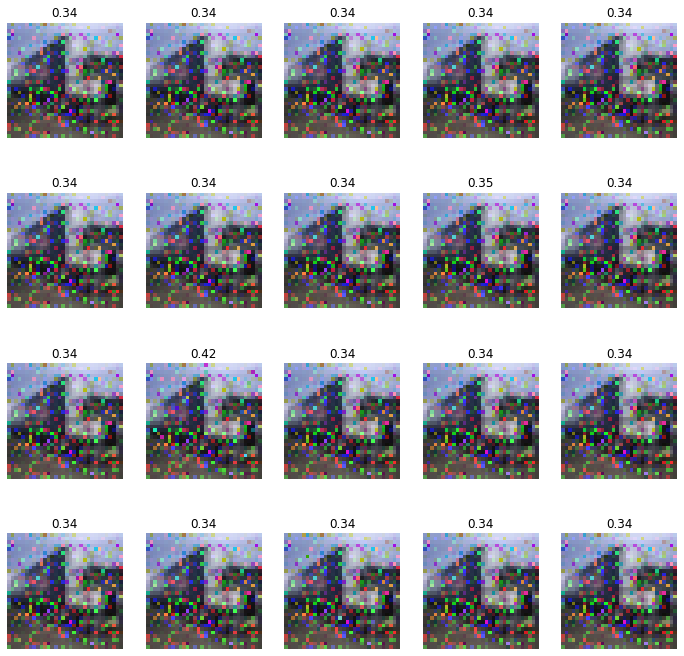

In [19]:
population , time_ = myObj.main()

In [ ]:
myPic = X_test_Flatten[34].copy()
myPicShape = X_test[0].shape
myPicOriginal = X_test[34].copy()

myObj = GeneticAdversarialRandom('cifar', model_cifar_cnn, 'CNN', myPicShape, myPicOriginal, myPic, 1, 0.005, 20, 5000, 0.1, 0.3)

All population are adversarial images after 97 iterations, after 287.1287271976471 seconds


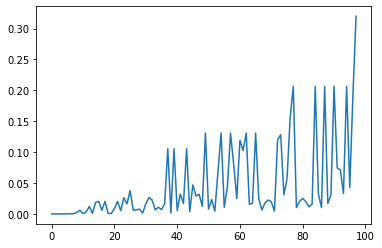

<Figure size 432x288 with 0 Axes>

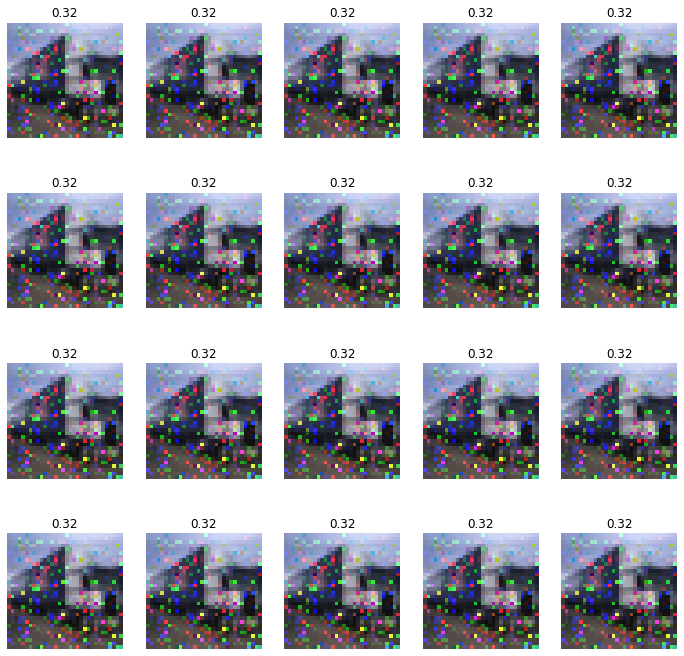

In [ ]:
population , time_ = myObj.main()

In [ ]:
model_cifar_ann = load_model("model_cifar_ann.h5")

First adversarial image is found at iteration number 26 iterations, after 73.45915222167969 seconds
First adversarial image is found at iteration number 27 iterations, after 76.12066292762756 seconds
All population are adversarial images after 35 iterations, after 98.08392858505249 seconds


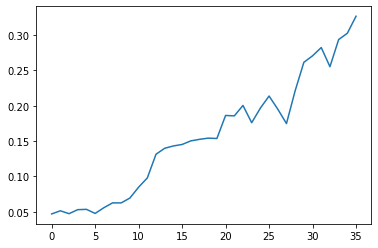

20


<Figure size 432x288 with 0 Axes>

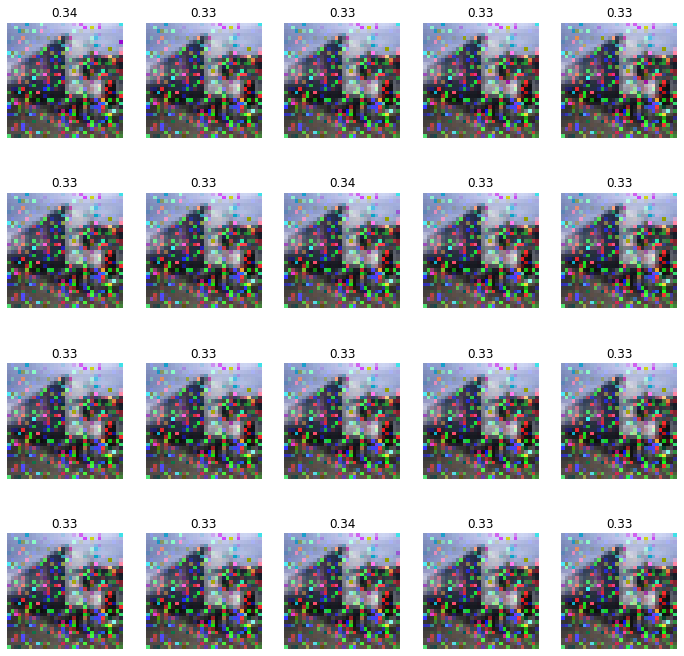

In [ ]:
myPic = X_test_Flatten[34].copy()
myPicShape = X_test[0].shape
myPicOriginal = X_test[34].copy()
myObj = GeneticAdversarialRandom('cifar', model_cifar_ann, 'ANN', myPicShape, myPicOriginal, myPic, 1, 0.005, 20, 5000, 0.1, 0.3)
pop , t = myObj.main()

print(len(pop))

In [28]:
(X_train, y_train), (X_test, y_test), (X_train_Flatten, X_test_Flatten) = preprocess('mnist')

11501568/11490434 [==============================] - 0s 0us/step


In [23]:
model_mnist_cnn = load_model("model_mnist_cnn.h5")

In [29]:
myPic = X_test_Flatten[34].copy()
myPicOriginal = X_test[34].copy()
myPicShape = X_test[0].shape
myObj = GeneticAdversarialRandomGumbelSSIM('mnist', model_mnist_cnn, 'CNN', myPicShape, myPicOriginal, myPic, 1, 0.005, 20, 5000, 0.1, 0.3)

All population are adversarial images after 28 iterations, after 71.77867722511292 seconds


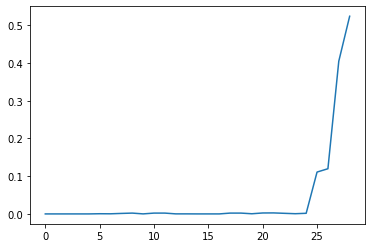

<Figure size 432x288 with 0 Axes>

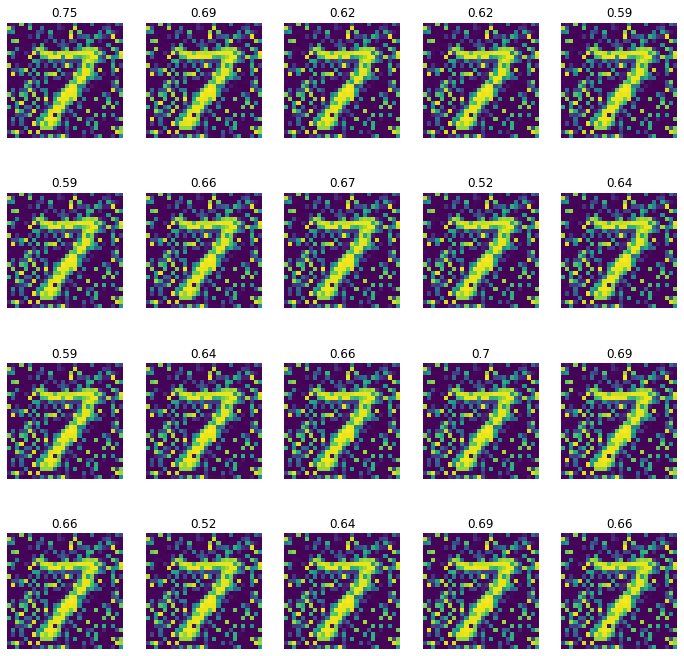

In [30]:
population , time_ = myObj.main()

In [31]:
model_mnist_ann = load_model("model_mnist_ann.h5")

In [32]:
myPic = X_test_Flatten[34].copy()
myPicOriginal = X_test[34].copy()
myPicShape = X_test[0].shape
myObj = GeneticAdversarialRandomGumbelSSIM('mnist', model_mnist_ann, 'ANN', myPicShape, myPicOriginal, myPic, 1, 0.005, 20, 5000, 0.1, 0.3)

First adversarial image is found at iteration number 98 iterations, after 241.08609652519226 seconds
All population are adversarial images after 107 iterations, after 262.94272327423096 seconds


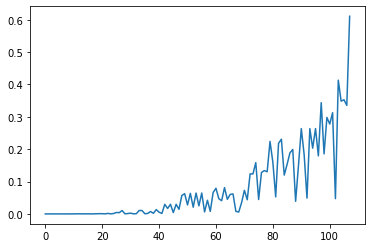

<Figure size 432x288 with 0 Axes>

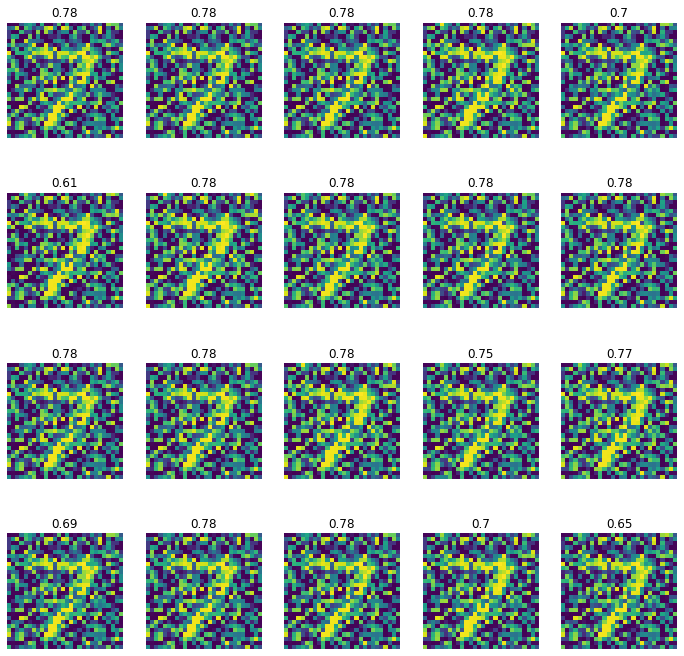

In [33]:
population , time_ = myObj.main()

In [34]:
model_mnist_ann = load_model("model_mnist_ann.h5")

First adversarial image is found at iteration number 17 iterations, after 48.29137063026428 seconds
All population are adversarial images after 24 iterations, after 66.82533288002014 seconds


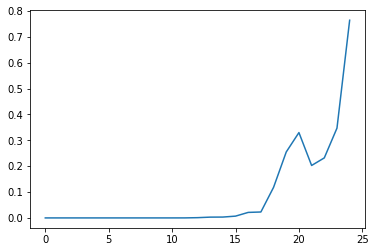

20


<Figure size 432x288 with 0 Axes>

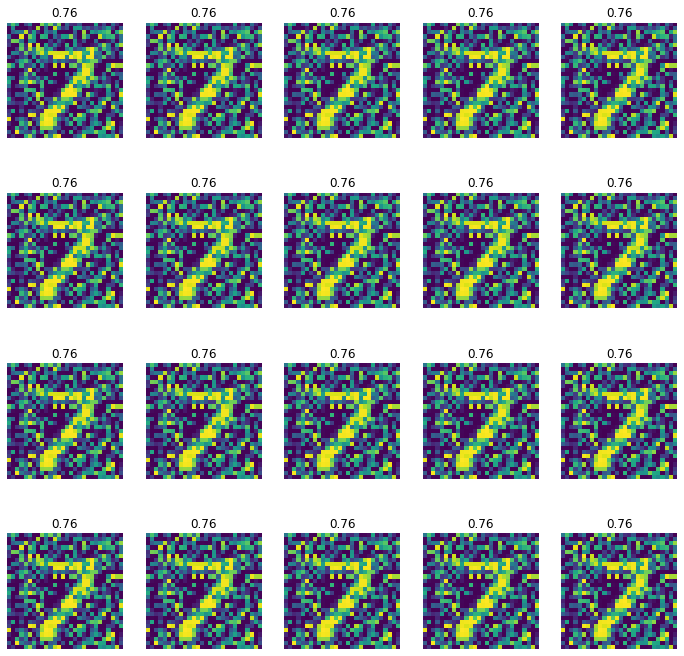

In [ ]:
myPic = X_test_Flatten[34].copy()
myPicShape = X_test[0].shape
myPicOriginal = X_test[34].copy()
myObj = GeneticAdversarialRandom('mnist', model_mnist_cnn, 'CNN', myPicShape, myPicOriginal, myPic, 1, 0.005, 20, 5000, 0.1, 0.3)
pop , t = myObj.main()


First adversarial image is found at iteration number 14 iterations, after 38.61508250236511 seconds
All population are adversarial images after 20 iterations, after 53.873947858810425 seconds


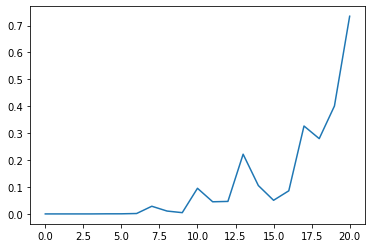

20


<Figure size 432x288 with 0 Axes>

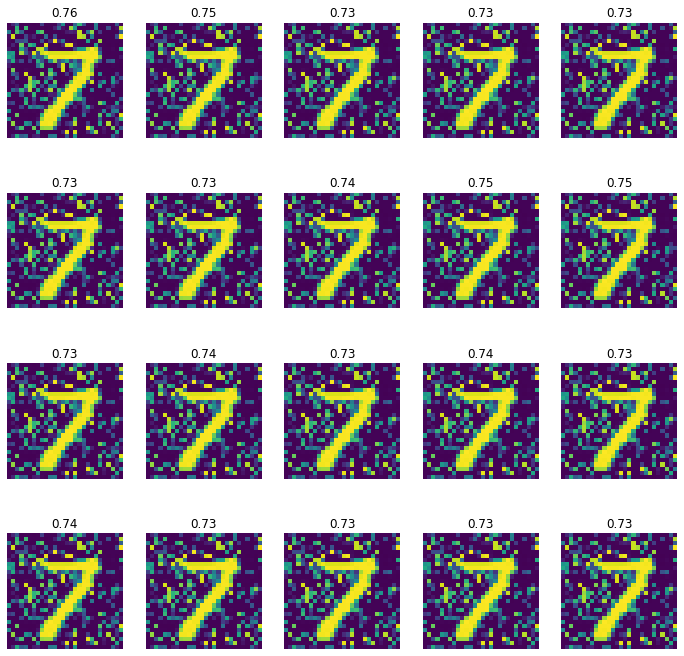

In [ ]:
myPic = X_test_Flatten[34].copy()
myPicShape = X_test[0].shape
myPicOriginal = X_test[34].copy()
myObj = GeneticAdversarialRandom('mnist', model_mnist_ann, 'ANN', myPicShape, myPicOriginal, myPic, 1, 0.005, 20, 5000, 0.1, 0.3)
pop , t = myObj.main()
